# Decision Tree

In [1]:
from math import log
import operator 

def createDataSet():
    
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    
    return dataSet, labels

In [2]:
def calcShannonEntropy(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet: #the number of unique elements and their occurence
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys(): labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
            prob = float(labelCounts[key])/numEntries
            shannonEnt -= prob * log(prob,2) # log base 2
    return shannonEnt

In [3]:
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis] #chop out axis used for splitting
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [4]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0])-1 #the last column is used for the labels
    baseEntropy = calcShannonEntropy(dataSet)
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures): #loop over all the features
        featList = [example[i] for example in dataSet] #create a list of all the examples of this feature
        uniqueVals = set(featList) # get a set of unique values
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEntropy(subDataSet)
        infoGain = baseEntropy - newEntropy # #calculate the info gain; ie reduction in entropy
        if (infoGain > bestInfoGain): #compare this to the best gain so far
            bestInfoGain = infoGain   #if better than current best, set to best
            bestFeature = i
    return bestFeature #returns an integer
            
            
        
    

In [5]:
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(), key = operator.itemgetter(1), reverse = True)
    return sortedClassCount[0][0]
    

In [6]:
def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList): 
        return classList[0]#stop splitting when all of the classes are equal
    if len(dataSet[0]) == 1: #stop splitting when there are no more features in dataSet
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]       #copy all of labels, so trees don't mess up existing labels
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree 
        

In [7]:
def classify(inputTree,featLabels,testVec):
    firstStr = inputTree.keys()[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    valueOfFeat = secondDict[key]
    if isinstance(valueOfFeat, dict): 
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else: classLabel = valueOfFeat
    return classLabel

In [8]:
def storeTree(inputTree,filename):
    import pickle
    fw = open(filename,'w')
    pickle.dump(inputTree,fw)
    fw.close()
    
def grabTree(filename):
    import pickle
    fr = open(filename)
    return pickle.load(fr)

In [9]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = myTree.keys()[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = myTree.keys()[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )
    
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = myTree.keys()[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

#def createPlot():
#    fig = plt.figure(1, facecolor='white')
#    fig.clf()
#    createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
#    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
#    plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
#    plt.show()

def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

#createPlot(thisTree)

In [10]:
myDat,labels=createDataSet()

In [11]:
import numpy as np
np.shape(myDat)

(5, 3)

In [12]:
calcShannonEntropy(myDat)

0.9709505944546686

In [15]:
myDat[0][-1]='maybe'
myDat

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [16]:
calcShannonEntropy(myDat)

1.3709505944546687

In [17]:
myDat, labels = createDataSet()

In [20]:
splitDataSet(myDat, 0, 1) #Here we are splitting the dataset from the first column with values = 1

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [21]:
splitDataSet(myDat, 1, 0) # Here, we are splitting the dataset for the second columnf for values = 0

[[1, 'no']]

In [22]:
chooseBestFeatureToSplit(myDat)

0

In [27]:
mayDat, labels = createDataSet()

In [28]:
myTree = createTree(myDat, labels)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [29]:
fr = open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels)

In [30]:
lensesTree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

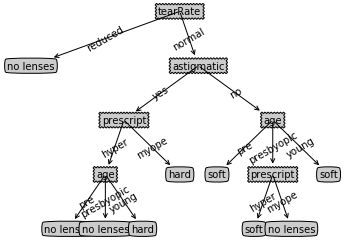

In [31]:
createPlot(lensesTree)

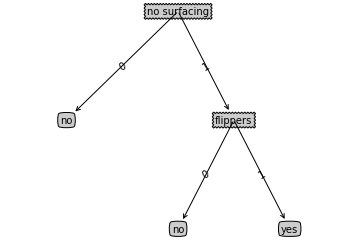

In [32]:
createPlot(myTree)

# Another decision tree

In [33]:
# For Python 2 / 3 compatability
from __future__ import print_function

In [34]:
# Toy dataset.
# Formato: cada fila es un ejemplo.
# La ultima colummna es la etiqueta.
# Las primeras dos columnas son caracteristicas.
#El segundo y sexto ejemplo tienenlas mismas caracteristicas a propósito 
#para ver como se clasifican.
training_data = [
    ['Green', 3, 'Apple'],
    ['Yellow', 3, 'Apple'],
    ['Red', 1, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
    ['Red', 2, 'Apple'],
]

In [35]:
# Etiquetas.
# para imprimir en el arbol.
header = ["color", "diameter", "label"]

In [36]:
def unique_vals(rows, col):
    """Encuentra los valores unicos de una columna en el dataset."""
    return set([row[col] for row in rows])

In [37]:
#######
# Demo:
#unique_vals(training_data, 2)
unique_vals(training_data, 2)
#######

{'Apple', 'Grape', 'Lemon'}

In [38]:
def class_counts(rows):
    """Cuenta el numero de elementos que hay para cada ejemplo en el dataset."""
    counts = {}  # un diccionario con etiqueta -> count.
    for row in rows:
        # en el formato de nuestro dataset, la etiqueta es la ultima columna
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [39]:
#######
# Demo:
class_counts(training_data)
#######

{'Apple': 3, 'Grape': 2, 'Lemon': 1}

In [40]:
def is_numeric(value):
    """Testea si un valor es numerico'."""
    return isinstance(value, int) or isinstance(value, float)

In [41]:
##### Demo:
is_numeric(0.445)
#is_numeric("Red")
#######

True

In [42]:
is_numeric('Sex')

False

In [43]:
class Question:
    """Una pregunta se hace para dividar el dataset.

    Esta clase genera una columna para un valor (e.g, 0 para Color) y un valor de la columna 
    (e.g., Green). El metodo 'match' se usa para comparar el valor de la caracteristica
    en un ejemplo con el valor de la caracteristica expresado en la pregunta.
    """

    def __init__(self, column, value):
        #print('Llamo al constructor')
        self.column = column
        self.value = value

    def match(self, example):
        # Compara el valor de la caraacteristica en un ejemplo
        # al valor de la caracteristica de la pregunta.
        #print('llamar match')
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

    def __repr__(self):
        # Esto ayuda a ver la pregunta en un formato mas legible.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (
            header[self.column], condition, str(self.value))

In [44]:
x = Question(1,2)

In [45]:
type(x)

instance

In [46]:
#######
# Demo:
# Pregunta para un atributo numerico
Question(1,2)

Is diameter >= 2?

In [47]:
# Pregunta para un valor categorico o nominal
q = Question(0, 'Green')
q

Is color == Green?

In [48]:
# ejemplo del dataset
example = training_data[0]
# ... veamos si matchea a la pregunta
q.match(example) # Sera cierto dado que el primer ejemplo es Green
#####


True

In [49]:
def partition(rows, question):
    """Particionar un dataset.

    Para cada fila en el dataset, checar si matchea (empareja) la pregunta If
    Si lo hace, se agrega a las 'true rows', de otra forma, se agrga a las 'false rows' 
    """
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows


In [50]:
#######
# Demo:
# Particionemos el dataset para ver cuales tienen la caracteristica 'Red'.
true_rows, false_rows = partition(training_data, Question(1, 3))
# Esto contiene todos las filas que tengan 'Red'.
true_rows

[['Green', 3, 'Apple'], ['Yellow', 3, 'Apple'], ['Yellow', 3, 'Lemon']]

In [51]:
false_rows

[['Red', 1, 'Grape'], ['Red', 1, 'Grape'], ['Red', 2, 'Apple']]

In [52]:
def gini(rows):
    """Calcula la immpureza de Gini para una lista de filas."""
    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity

In [53]:
#######
# Demo:
# Veamos un ejemplo para entender como funciona la impureza de Gini
# Para un dataset sin mas de un elemento mezclado.
no_mixing = [['Apple'],
              ['Apple']]
# dara cero
gini(no_mixing)


0.0

In [54]:


# para una mezcla 50:50 de Apple y Orange
some_mixing = [['Apple'],
               ['Orange']]
#Regresa 0.5, significa que hay un 50% de probabilidad 
#de clasificar erroneamente un ejemplo aleatorio cuando
#se elige del dataset
gini(some_mixing)



0.5

In [55]:


#veamos un dataset con muchas etiquetas
lots_of_mixing = [['Apple'],
                  ['Orange'],
                  ['Grape'],
                  ['Grapefruit'],
                  ['Blueberry']]
#Regresa mayor impureza
gini(lots_of_mixing)
#######



0.7999999999999998

In [56]:
gini(training_data)

0.6111111111111112

In [57]:
def info_gain(left, right, current_uncertainty):
    """Ganancia de informacion.
    
    La impureza del nodo inicial menos la impureza pesada del resultado de la particion
    de dos nodos hijos.
    """
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

In [58]:
#######
# Demo:
# Calcular la impureza del dataset.
current_uncertainty = gini(training_data)
current_uncertainty

0.6111111111111112

In [59]:
#Cuanta informacion se gana si se particiona sobre el atributo 'Green'?
true_rows, false_rows = partition(training_data, Question(0, 'Green'))
info_gain(true_rows, false_rows, current_uncertainty)

0.07777777777777783

In [60]:
#Y si se hace sobre el 'Red'
true_rows, false_rows = partition(training_data, Question(0,'Red'))
info_gain(true_rows, false_rows, current_uncertainty)

0.16666666666666674

In [61]:
#Mira los diferentes resultados y ve cual resulta mas mezclado
true_rows, false_rows = partition(training_data, Question(0,'Red'))

true_rows

[['Red', 1, 'Grape'], ['Red', 1, 'Grape'], ['Red', 2, 'Apple']]

In [62]:

false_rows

[['Green', 3, 'Apple'], ['Yellow', 3, 'Apple'], ['Yellow', 3, 'Lemon']]

In [63]:
#por otro lado, particionoar sobre 'Green' no parece ayudar mucho.
true_rows, false_rows = partition(training_data, Question(0,'Green'))

true_rows

[['Green', 3, 'Apple']]

In [64]:

false_rows
#######

[['Yellow', 3, 'Apple'],
 ['Red', 1, 'Grape'],
 ['Red', 1, 'Grape'],
 ['Yellow', 3, 'Lemon'],
 ['Red', 2, 'Apple']]

In [65]:
def find_best_split(rows):
    """Encontrar el mejor split mediante una pregunta, iterando sobre todo el par caracteristica/valor
    y calculando la ganancia de informacion."""
    best_gain = 0  # hacer un seguimiento de la mejor gananncia de informacion
    best_question = None  # Hacer un seguimiento del par caracteristica/valor que lo produce
    current_uncertainty = gini(rows)
    n_features = len(rows[0]) - 1  # numero de columnas 
    
    for col in range(n_features):  # para cada caracterisitica

        values = set([row[col] for row in rows])  # valores unicos en la columna

        for val in values:  # para cada valor

            question = Question(col, val)

            # intentar dividir el dataset
            true_rows, false_rows = partition(rows, question)

            # saltarse el split si no divide el dataset
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            #Calcular la ganancia de informacion de esta division
            gain = info_gain(true_rows, false_rows, current_uncertainty)

            
        
            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [66]:
#######
# Demo:
#Encontrar la mejor pregunta para hacer
best_gain, best_question = find_best_split(training_data)
best_question
#######

Is diameter >= 2?

In [67]:
true_rows, false_rows = partition(training_data, Question(1,2))

In [68]:
true_rows

[['Green', 3, 'Apple'],
 ['Yellow', 3, 'Apple'],
 ['Yellow', 3, 'Lemon'],
 ['Red', 2, 'Apple']]

In [69]:
false_rows

[['Red', 1, 'Grape'], ['Red', 1, 'Grape']]

In [70]:
class Leaf:
    """Un Leaf Node clasifica los datos.

    Esto contiene un diccionaro de clase (e.g., "Apple") -> numero de veces
    que aparece en las filas del dataset restante que ha llegado a esta hoja.
    """

    def __init__(self, rows):
        self.predictions = class_counts(rows)

In [71]:
x=Leaf(true_rows)

In [72]:
x.predictions

{'Apple': 3, 'Lemon': 1}

In [73]:
class Decision_Node:
    """Un Decision node hace una pregunta.

    Esto contiene una referencia a la pregunta y los dos nodos hijos"""

    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [74]:
Decision_Node(Question(1,2),true_rows,false_rows).false_branch

[['Red', 1, 'Grape'], ['Red', 1, 'Grape']]

In [75]:
def build_tree(rows):
    """Construye el arbol.

    Reglas de recursion:
    1) creer que funciona. 
    2) Ver que para el caso final no hay mayor ganancia de informacion en ese split.
    3) Devolver un nodo hoja
    """

    #Intentar particionar el dataset en cada atributo unico
    #Calcula la ganancia de informacion
    #Devuelve la pregunta que produce la mayor ganancia.
    gain, question = find_best_split(rows)

    # #Caso final: no hay mayor ganancia de informacion
    # COmo ya no se puede hacer ninguna pregunta
    # devuelve un nodo hoja.
    if gain == 0:
        return Leaf(rows)

    #LLegar aqui significa que encontramos un par util de caracteristica/valor
    # para hacer la particion.
    true_rows, false_rows = partition(rows, question)

    # Construir recursivamente la rama que contiene valores verdaderos (True).
    true_branch = build_tree(true_rows)

    # COnstruir recursivamente la rama que contiene valores falsos(False).
    false_branch = build_tree(false_rows)

    #DEvuelve un nodo donde se hace una pregunta
    #Esto registra el mejor par caracteristica/valor realizar la pregunta
    # asi como en ramas inferiores
    #dependiendo de la respuesta
    return Decision_Node(question, true_branch, false_branch)

In [76]:
def print_tree(node, spacing=""):
    """Funcion para imprimir el arbol."""

    # Caso final, llegamos a una hoja
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # imprimir la pregunta de este nodo
    print (spacing + str(node.question))

    # Llamar esta funcion recursivamente en la rama verdadera
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Llamar esta funcion recursivamente para la rama falsa
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [77]:
my_tree = build_tree(training_data)

In [78]:
print_tree(my_tree)

Is diameter >= 2?
--> True:
  Is color == Yellow?
  --> True:
    Predict {'Lemon': 1, 'Apple': 1}
  --> False:
    Predict {'Apple': 2}
--> False:
  Predict {'Grape': 2}


In [79]:
def classify(row, node):
    """Reglas de clasificacion."""

    # Caso final: llegamos a un nodo hoja
    if isinstance(node, Leaf):
        return node.predictions

    # Decide si seguir la rama verdadera o la falsa.
    #Compara el par caracteristica/valor guardado en el nodo al
    #ejemplo que esta considerando
    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)



In [80]:
#######
# Demo:
#EL arbol predice que la primera fila del training set es 'apple' y dice cuantos elementos hay
classify(training_data[0], my_tree)
#######

{'Apple': 2}

In [81]:
def print_leaf(counts):
    """Una manera de imprimir los valores de las hojas."""
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [82]:
#######
# Demo:
print_leaf(classify(training_data[0], my_tree))
#######

{'Apple': '100%'}

In [84]:
#######
# Demo:
#En otro ejemplo, hay una probabilidad 50:50 de que lo seleccionado sea
# 'Apple' o 'Lemon
print_leaf(classify(training_data[1], my_tree))
#######

{'Apple': '50%', 'Lemon': '50%'}

In [85]:


# Evaluar
testing_data = [
    ['Green', 3, 'Apple'],
    ['Yellow', 4, 'Apple'],
    ['Red', 2, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
]



In [86]:
for row in testing_data:
    print ("Actual: %s. Predicted: %s" %
           (row[-1], print_leaf(classify(row, my_tree))))

Actual: Apple. Predicted: {'Apple': '100%'}
Actual: Apple. Predicted: {'Lemon': '50%', 'Apple': '50%'}
Actual: Grape. Predicted: {'Apple': '100%'}
Actual: Grape. Predicted: {'Grape': '100%'}
Actual: Lemon. Predicted: {'Lemon': '50%', 'Apple': '50%'}


# A decision tree for more features

We want to make a decision tree based on 12 training vectors that will decide to wait or not for a spot in a restaurant depending don different features

In [87]:
#REstaurant domain dataset

rest_training_data = [
    ['Yes', 'No', 'No','Yes', 'Some', '$$$', 'No', 'Yes', 'French', '0-10','Yes'],
    ['Yes', 'No', 'No','Yes', 'Full', '$', 'No', 'No', 'Thai', '30-60','No'],
    ['No', 'Yes', 'No','No', 'Some', '$', 'No', 'No', 'Burger', '0-10','Yes'],
    ['Yes', 'No', 'Yes','Yes', 'Full', '$', 'Yes', 'No', 'Thai', '10-30','Yes'],
    ['Yes', 'No', 'Yes','No', 'Full', '$$$', 'No', 'Yes', 'French', '>60','No'],
    ['No', 'Yes', 'No','Yes', 'Some', '$$', 'Yes', 'Yes', 'Italian', '0-10','Yes'],
    ['No', 'Yes', 'No','No', 'None', '$', 'Yes', 'No', 'Burger', '0-10','No'],
    ['No', 'No', 'No','Yes', 'Some', '$$', 'Yes', 'Yes', 'Thai', '0-10','Yes'],
    ['No', 'Yes', 'Yes','No', 'Full', '$', 'Yes', 'No', 'Burger', '0-10','No'],
    ['Yes', 'Yes', 'Yes','Yes', 'Full', '$$$', 'No', 'Yes', 'Italian', '10-30','No'],
    ['No', 'No', 'No','No', 'None', '$', 'No', 'No', 'Thai', '0-10','No'],
    ['Yes', 'Yes', 'Yes','Yes', 'Full', '$', 'No', 'No', 'Burger', '30-60','Yes'],
    
]

In [88]:
header_rest =['Alternate?', 'Bar?', 'Friday?','Hungry?', 'Patrons?', 'Price?', 'Rain?', 'Reservation?', 'Food Type?', 'Wait estimation?', 'Will Wait?']

In [89]:
print(unique_vals(rest_training_data,9))
print(unique_vals(rest_training_data,4))
print(unique_vals(rest_training_data,8))

set(['10-30', '30-60', '0-10', '>60'])
set(['None', 'Full', 'Some'])
set(['Burger', 'Thai', 'French', 'Italian'])


In [90]:
class_counts(rest_training_data) #In this case, tha algorithm is indicating the labels of the decision column

{'No': 6, 'Yes': 6}

In [91]:
is_numeric('None')

False

In [101]:


class Question:
    """Se hace una pregunta para dividir el dataset.
    
    Esta class registra un numero de columna (e.g., 0 para 'Alternate') y un valor de la columna
    (e.g., Yes). El metodo 'match'compara el valor de la caracteristica
    en un ejemplo al valor de la caracteristica almacenada en la pregunta.
    """

    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        #Compara el valor del atributo en un ejemplo al valor del atributo de la pregunta
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

    def __repr__(self):
        
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return " %s %s %s" % (
            header_rest[self.column], condition, str(self.value))



In [104]:
q1 = Question(0,'Yes')
q1

 Alternate? == Yes

In [105]:
#######
# Demo:

true_rows, false_rows = partition(rest_training_data, Question(8, 'Burger'))

true_rows

[['No', 'Yes', 'No', 'No', 'Some', '$', 'No', 'No', 'Burger', '0-10', 'Yes'],
 ['No', 'Yes', 'No', 'No', 'None', '$', 'Yes', 'No', 'Burger', '0-10', 'No'],
 ['No', 'Yes', 'Yes', 'No', 'Full', '$', 'Yes', 'No', 'Burger', '0-10', 'No'],
 ['Yes',
  'Yes',
  'Yes',
  'Yes',
  'Full',
  '$',
  'No',
  'No',
  'Burger',
  '30-60',
  'Yes']]

In [106]:

false_rows

[['Yes',
  'No',
  'No',
  'Yes',
  'Some',
  '$$$',
  'No',
  'Yes',
  'French',
  '0-10',
  'Yes'],
 ['Yes', 'No', 'No', 'Yes', 'Full', '$', 'No', 'No', 'Thai', '30-60', 'No'],
 ['Yes', 'No', 'Yes', 'Yes', 'Full', '$', 'Yes', 'No', 'Thai', '10-30', 'Yes'],
 ['Yes', 'No', 'Yes', 'No', 'Full', '$$$', 'No', 'Yes', 'French', '>60', 'No'],
 ['No',
  'Yes',
  'No',
  'Yes',
  'Some',
  '$$',
  'Yes',
  'Yes',
  'Italian',
  '0-10',
  'Yes'],
 ['No', 'No', 'No', 'Yes', 'Some', '$$', 'Yes', 'Yes', 'Thai', '0-10', 'Yes'],
 ['Yes',
  'Yes',
  'Yes',
  'Yes',
  'Full',
  '$$$',
  'No',
  'Yes',
  'Italian',
  '10-30',
  'No'],
 ['No', 'No', 'No', 'No', 'None', '$', 'No', 'No', 'Thai', '0-10', 'No']]

In [107]:
current_uncertainity = gini(rest_training_data)

true_rows, false_rows = partition(rest_training_data, Question(0, 'Yes'))
info_gain(true_rows, false_rows, current_uncertainty)

0.11111111111111116

In [108]:
#Si particionamos con el precio
true_rows, false_rows = partition(rest_training_data, Question(5,'$$'))
info_gain(true_rows, false_rows, current_uncertainty)

0.21111111111111114

In [109]:

true_rows, false_rows = partition(rest_training_data, Question(5,'$$'))

true_rows

[['No',
  'Yes',
  'No',
  'Yes',
  'Some',
  '$$',
  'Yes',
  'Yes',
  'Italian',
  '0-10',
  'Yes'],
 ['No', 'No', 'No', 'Yes', 'Some', '$$', 'Yes', 'Yes', 'Thai', '0-10', 'Yes']]

In [110]:
false_rows

[['Yes',
  'No',
  'No',
  'Yes',
  'Some',
  '$$$',
  'No',
  'Yes',
  'French',
  '0-10',
  'Yes'],
 ['Yes', 'No', 'No', 'Yes', 'Full', '$', 'No', 'No', 'Thai', '30-60', 'No'],
 ['No', 'Yes', 'No', 'No', 'Some', '$', 'No', 'No', 'Burger', '0-10', 'Yes'],
 ['Yes', 'No', 'Yes', 'Yes', 'Full', '$', 'Yes', 'No', 'Thai', '10-30', 'Yes'],
 ['Yes', 'No', 'Yes', 'No', 'Full', '$$$', 'No', 'Yes', 'French', '>60', 'No'],
 ['No', 'Yes', 'No', 'No', 'None', '$', 'Yes', 'No', 'Burger', '0-10', 'No'],
 ['No', 'Yes', 'Yes', 'No', 'Full', '$', 'Yes', 'No', 'Burger', '0-10', 'No'],
 ['Yes',
  'Yes',
  'Yes',
  'Yes',
  'Full',
  '$$$',
  'No',
  'Yes',
  'Italian',
  '10-30',
  'No'],
 ['No', 'No', 'No', 'No', 'None', '$', 'No', 'No', 'Thai', '0-10', 'No'],
 ['Yes',
  'Yes',
  'Yes',
  'Yes',
  'Full',
  '$',
  'No',
  'No',
  'Burger',
  '30-60',
  'Yes']]

In [111]:
best_gain, best_question = find_best_split(rest_training_data)
best_question


 Patrons? == Some

In [112]:
best_gain

0.25

In [113]:
my_2_tree = build_tree(rest_training_data)


In [114]:
print_tree(my_2_tree)

 Patrons? == Some
--> True:
  Predict {'Yes': 4}
--> False:
   Hungry? == No
  --> True:
    Predict {'No': 4}
  --> False:
     Food Type? == Burger
    --> True:
      Predict {'Yes': 1}
    --> False:
       Rain? == No
      --> True:
        Predict {'No': 2}
      --> False:
        Predict {'Yes': 1}


In [117]:
rest_testing_data = [
    #['Yes', 'Yes', 'Yes','Yes', 'Some', '$$$', 'No', 'Yes', 'French', '0-10','Yes'],
    #['Yes', 'No', 'Yes','Yes', 'Some', '$$', 'Yes', 'No', 'Burger', '30-60','Yes'],
    #['No', 'Yes', 'No','Yes', 'Full', '$$$', 'Yes', 'Yes', 'Burger', '0-10','No'],
    #['No', 'No', 'Yes','Yes', 'Some', '$$', 'Yes', 'No', 'French', '10-30','Yes'],
    ['Yes', 'No', 'Yes','No', 'Full', '$$', 'No', 'No', 'French', '>60','No'],
    ['No', 'No', 'Yes','No', 'None', '$$', 'Yes', 'Yes', 'Thai', '0-10','No'],
    ['Yes', 'No', 'No','No', 'Some', '$$', 'No', 'No', 'Thai', '0-10','Yes'],
    ['No', 'No', 'No','No', 'None', '$$', 'Yes', 'No', 'Thai', '0-10','No'],
    ['Yes', 'Yes', 'Yes','No', 'Full', '$$$', 'No', 'Yes', 'Thai', '0-10','Yes'],
    #['No', 'Yes', 'Yes','No', 'Some', '$$$', 'No', 'Yes', 'Italian', '10-30','Yes'],
    #['No', 'Yes', 'Yes','No', 'Some', '$$$', 'No', 'Yes', 'Thai', '0-10','Yes'],
    #['Yes', 'Yes', 'Yes','Yes', 'Full', '$$$', 'Yes', 'Yes', 'Burger', '30-60','No'],
    
]

In [118]:
for row in rest_testing_data:
    print ("Actual: %s. Predicted: %s" %
           (row[-1], print_leaf(classify(row, my_2_tree))))

Actual: No. Predicted: {'No': '100%'}
Actual: No. Predicted: {'No': '100%'}
Actual: Yes. Predicted: {'Yes': '100%'}
Actual: No. Predicted: {'No': '100%'}
Actual: Yes. Predicted: {'No': '100%'}


# Decision Tree and Random Forest scikitlearn

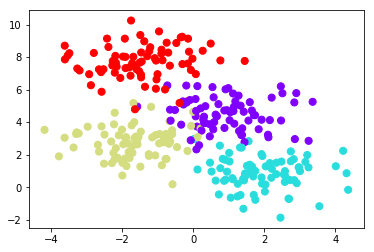

In [119]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');
plt.show()

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it. This figure presents a visualization of the first four levels of a decision tree classifier for this data:

In [120]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [121]:
import numpy as np
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

/home/jazhiel/.local/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


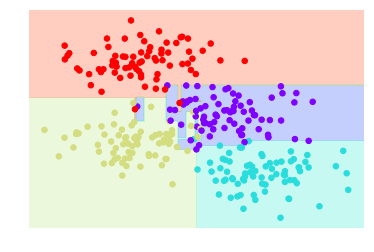

In [122]:
visualize_classifier(DecisionTreeClassifier(), X, y)

## Bagging

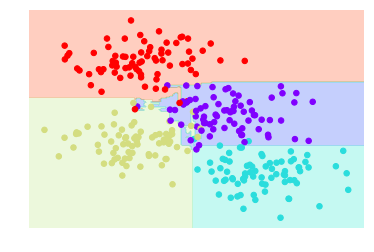

In [123]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

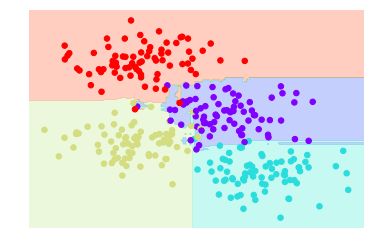

In [124]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y)

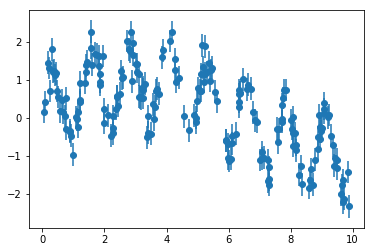

In [125]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

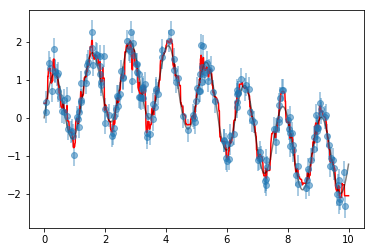

In [126]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

In [127]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

['images', 'data', 'target_names', 'DESCR', 'target']

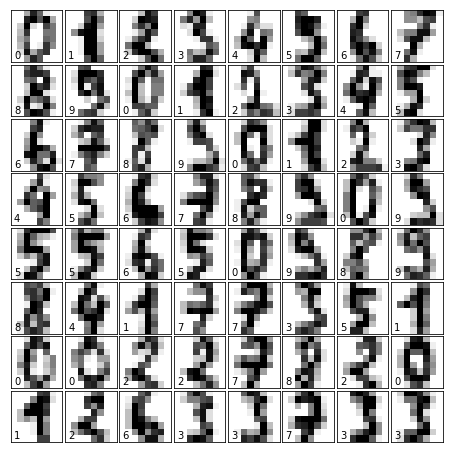

In [128]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [129]:
from sklearn.model_selection import train_test_split

#from sklearn.cross_validation import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [130]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))


              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.95      0.97        44
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.95      1.00      0.97        36
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.94      0.97        51
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

   micro avg       0.98      0.98      0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



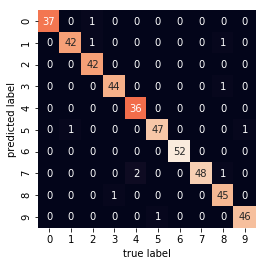

In [131]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');